In [1]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

#pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

W0602 22:49:25.417795 18220 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'Yamaha YPG-235 76-Key Portable Grand Piano Premium Pack'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [3]:
import re

def remove_banned(s,words):
    #words = sorted(words, key=len, reverse=True)
    pattern = '|'.join(words)
    s = re.sub(pattern, '', s, flags = re.I) # remove words
    s = re.sub(r'[0-9]+', '', s) # remove numbers
    s = re.sub('\s+', ' ', s, flags = re.I) # remove extra blank space'
    return s

bannedWords = ['hi', 'hi you', 'hello', 'and you']
s = "Hi, Hello, hi you, How are Tim and you doing"

print(remove_banned(s,bannedWords))

, , you, How are Tim doing


In [4]:
word_list = pd.read_csv('sentiment/wordlist.csv')
word_list = word_list.dropna()
word_list['count'] = word_list['word'].apply(lambda x: len(x.split()))
wd2 = word_list

In [5]:
word_list = word_list.sort_values(by=['count'],ascending =False).reset_index(drop=True)
word_list['word'] = word_list['word'].apply(lambda x: x+' ')
wordlist = word_list.loc[word_list['count']<10, ['word']]
wordlist = wordlist['word'].tolist()

In [7]:
one_word = wd2[wd2['count']==1]['word'].tolist()
mylist = ['love','loves','loved','like','likes','liked','enjoy','enjoys','enjoyed',
            'hate','hates','hated','do','does','did','don','don\'t','want','wants','wanted','ve']
subject = ['yamaha','ypg','piano','235','grand','premium','keyboard']
for i in range(len(subject)):
    subject[i] = subject[i].lower()
one_word.extend(mylist)
one_word.extend(subject)
one_word = set(one_word)

In [8]:
def clean_review(x):

    words = one_word

    resultwords  = [word for word in re.split("[.,; :-?!&]+",x) if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [9]:
reviews.head()

,text
0,This electronic piano is the best
1,I love it with its many features and options
2,I am really learning to playt he piano with it...
3,This was a great cheap way to get back into pl...
4,After having this keyboard for almost two year...


In [10]:
import contractions
reviews['removed'] = reviews['text'].apply(lambda x: remove_banned(x,wordlist))
reviews['removed'] = reviews['removed'].apply(lambda x: clean_review(x))
reviews['removed'] = reviews['removed'].apply(lambda x: contractions.fix(x))

In [11]:
def clean_numbers(line):
    line = re.sub('[0-9%]+','',line)
    line = re.sub(' +', ' ',line)
    return line.strip()

In [12]:
reviews['removed'] = reviews['removed'].apply(lambda x: clean_numbers(x))

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from itertools import islice


In [14]:
cvec = CountVectorizer(stop_words='english', min_df=0.001, max_df=.2, ngram_range=(2,3))
cvec.fit(reviews.removed)
len(cvec.vocabulary_)
#list(islice(cvec.vocabulary_.items(), 20))

145

In [15]:
cvec_counts = cvec.transform(reviews.removed)
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': cvec.get_feature_names(), 'occurrences': occ})
#counts_df.sort_values(by='occurrences', ascending=False).head(20)

sparse matrix shape: (2292, 145)
nonzero count: 614
sparsity: 0.18%


In [16]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=False).reset_index(drop=True)

In [17]:
key_words = weights_df[weights_df.weight>=0.0005]

In [18]:
len(key_words)

145

In [19]:
key_words

,term,weight
0,learn play,0.006818
1,stand headphones,0.005145
2,sustain pedal,0.005028
3,power adapter,0.004684
4,keys weighted,0.004646
5,weighted keys,0.004501
6,learning play,0.003490
7,bells whistles,0.003490
8,headphones work,0.003378
9,head phones,0.003349


In [20]:
import pandas as pd
import time, os, shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.cluster import DBSCAN
from nltk.parse import CoreNLPParser
from sklearn import decomposition as dc

In [21]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)


Instructions for updating:
Colocations handled automatically by placer.


W0602 22:52:25.667885 18220 deprecation.py:323] From C:\Users\betty\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [22]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    key_words['embedding'] = pd.Series(list(session.run(embed(list(key_words['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:52:47.229502 18220 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 3.148369073867798


In [23]:
terms = key_words['term'].tolist()
embs = key_words['embedding'].tolist()

In [24]:
##
X = np.array(embs,)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(embs)

In [25]:
X.shape

(145, 512)

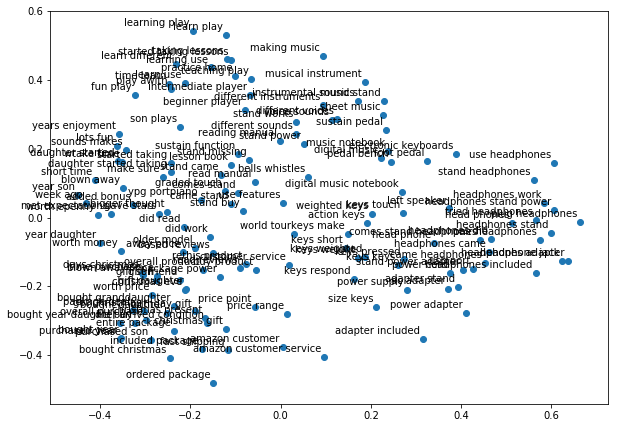

In [27]:
import matplotlib.pyplot as plt

labels = terms 
plt.figure(figsize=(10, 7))  
plt.subplots_adjust(bottom=0.1)  
plt.scatter(X2[:,0],X2[:,1], label='True Position')

for label, x, y in zip(labels, X2[:, 0], X2[:, 1]):  
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()  

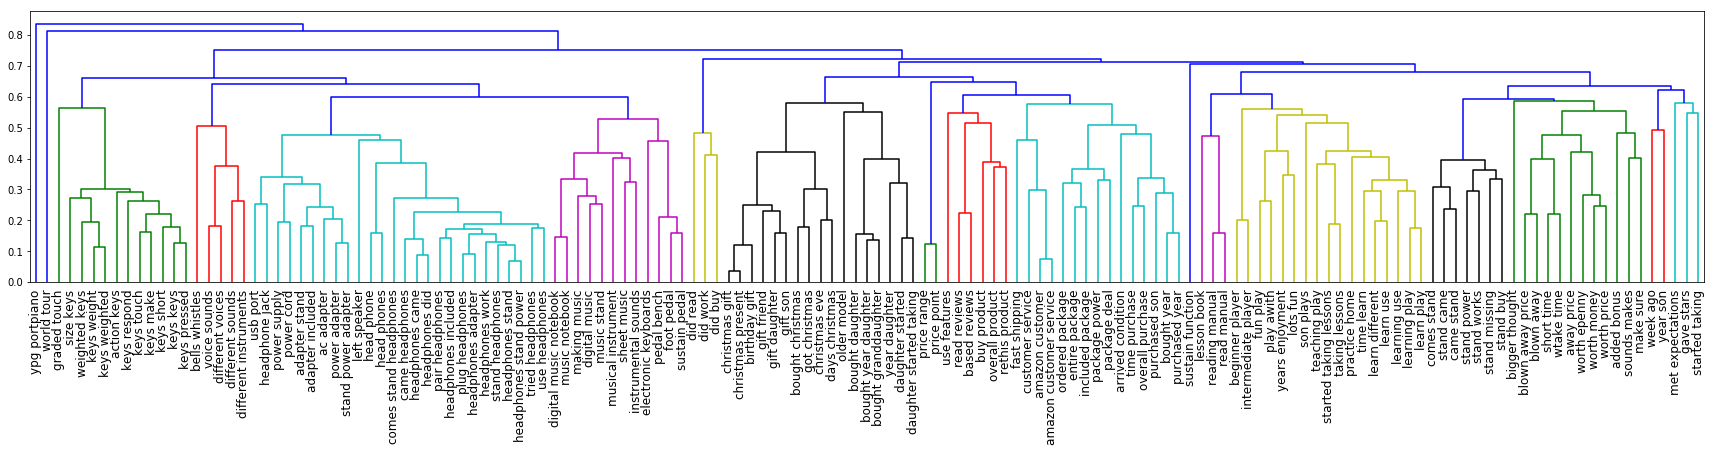

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist

#dist_condensed = pdist(X)
#linked = linkage(X, 'single',metric='cosine',optimal_ordering=True)
linked = linkage(X, 'average', metric='cosine',optimal_ordering=True)
labelList = terms

plt.figure(figsize=(30, 5))  
dh = dendrogram(linked,  
            orientation='top',
            labels=labelList,
            leaf_font_size=12,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [29]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.2.


In [30]:
import matplotlib.pyplot as plt  
import pandas as pd  
%matplotlib inline
import numpy as np  
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold =0.45)  
term_clusters = cluster.fit_predict(X)  
term_clusters

array([ 1,  7, 13, 19, 16, 16,  1, 33,  7,  7,  5,  1,  4,  4, 24, 18, 27,
       20,  1,  3, 21,  6, 31,  2,  8,  7, 32, 11, 15, 19, 30, 13, 23, 22,
       11,  4, 10,  9,  9, 18, 19, 16, 24,  2, 11,  0,  7,  7, 39, 19, 35,
        6, 12, 41,  1, 16,  6, 25,  8,  1, 12,  6, 16, 16,  7, 14, 16,  9,
       16, 10, 15, 42, 34, 11,  7,  4,  7,  6, 19, 36, 10,  2, 16, 43,  7,
        7,  0, 16, 37,  7, 14,  4, 19,  3, 38,  2,  4,  4, 18,  1, 28, 16,
        0,  1, 26, 19,  2,  8, 21,  2, 30, 18, 19,  4, 18,  4,  4, 12,  7,
       18,  1,  0,  7, 29, 40, 13,  9,  5, 19,  7, 18, 20, 20,  8, 10,  2,
        2, 15, 15, 15,  7,  9,  9,  1, 17], dtype=int64)

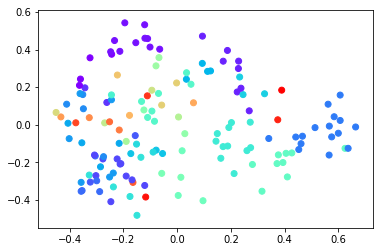

In [32]:
plt.scatter(X2[:,0],X2[:,1], c=cluster.labels_, cmap='rainbow') 

In [33]:
cluster_numbers = np.amax(term_clusters)
print('Number of keyword clusters:',cluster_numbers)

Number of keyword clusters: 43


In [34]:
cluster_data = {'term':terms, 'cluster':term_clusters}
df_cluster = pd.DataFrame(cluster_data)

In [35]:
df_cluster.to_csv("output/yamaha_piano.csv",index=False)
####### load
df_cluster = pd.read_csv("output/yamaha_piano.csv")
cluster_numbers = np.amax(df_cluster.cluster.tolist())

In [36]:
# Load google Universal Sentence Encoder
module_dir ="downloads/encoder-DNA" #"downloads/encoder"
embed = hub.Module(module_dir)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    df_cluster['embedding'] = pd.Series(list(session.run(embed(list(df_cluster['term'])))))
    end_time1=time.time()
    print('time1:',(end_time1-start_time))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:57:13.063688 18220 saver.py:1483] Saver not created because there are no variables in the graph to restore


time1: 4.236924171447754


In [37]:
df_cluster.head()

,term,cluster,embedding
0,learn play,1,"[0.013417366, -0.019909976, -0.014732761, 0.01..."
1,stand headphones,7,"[0.013813133, -0.00942875, -0.0063091265, 0.02..."
2,sustain pedal,13,"[0.04774402, 0.0084535405, -0.032584395, 0.035..."
3,power adapter,19,"[0.056282938, 0.017694524, -0.036701776, 0.041..."
4,keys weighted,16,"[0.0050130417, 0.046894237, -0.040188488, 0.02..."


In [38]:
group = []
emb_group = []
for i in range(cluster_numbers+1):
    terms_in_group = df_cluster.loc[df_cluster['cluster']==i]['term'].tolist()
    embs_in_group = df_cluster.loc[df_cluster['cluster']==i]['embedding'].tolist()
    if len(terms_in_group)>=3:
        group.append(terms_in_group)
        emb_group.append(embs_in_group)
        print('Group '+str(i)+':\n',terms_in_group,'\n')

Group 0:
 ['play awith', 'years enjoyment', 'fun play', 'lots fun'] 

Group 1:
 ['learn play', 'learning play', 'teaching play', 'taking lessons', 'learning use', 'practice home', 'learn use', 'learn different', 'time learn', 'started taking lessons'] 

Group 2:
 ['sheet music', 'music stand', 'instrumental sounds', 'musical instrument', 'digital music', 'making music', 'music notebook', 'digital music notebook'] 

Group 4:
 ['gift daughter', 'christmas gift', 'got christmas', 'christmas eve', 'bought christmas', 'christmas present', 'gift friend', 'gift son', 'days christmas', 'birthday gift'] 

Group 6:
 ['bought year', 'purchased year', 'purchased son', 'overall purchase', 'time purchase'] 

Group 7:
 ['stand headphones', 'headphones work', 'head phones', 'headphones stand', 'headphones came', 'use headphones', 'pair headphones', 'came headphones', 'head phone', 'headphones did', 'headphones included', 'tried headphones', 'plug headphones', 'headphones adapter', 'comes stand headpho

In [39]:
avg_embs = []

for embs in emb_group:
    temp_avg = np.zeros(len(embs[0]))
    for term_emb1 in embs:
        temp_avg = temp_avg+term_emb1
        term_avg = temp_avg/len(embs)
    avg_embs.append(term_avg)

In [40]:
data2 = {'terms':group, 'avg_emb':avg_embs}
cluster_embs = pd.DataFrame(data2)
cluster_embs

,terms,avg_emb
0,"[play awith, years enjoyment, fun play, lots fun]","[-0.05095776217058301, -0.007584649036289193, ..."
1,"[learn play, learning play, teaching play, tak...","[-0.0018465096462023211, 0.0025667034671641884..."
2,"[sheet music, music stand, instrumental sounds...","[0.0006908946670591831, 0.017204834133735858, ..."
3,"[gift daughter, christmas gift, got christmas,...","[-0.01056178801227361, 0.03288431700893853, -0..."
4,"[bought year, purchased year, purchased son, o...","[0.024546201527118682, 0.022398967854678632, -..."
5,"[stand headphones, headphones work, head phone...","[0.013331842819752637, 0.01163625622211839, -0..."
6,"[wtake time, short time, blown away, blown awa...","[0.022165272384881973, 0.02075210679322481, -0..."
7,"[bought daughter, year daughter, bought grandd...","[-0.023907396321495373, -0.0259388560273995, -..."
8,"[worth price, worth epenny, worth money, away ...","[0.019497516099363565, 0.01667876192368567, -0..."
9,"[different sounds, different voices, different...","[-0.004216802539303899, 0.014518231037072837, ..."


In [41]:
import pickle
pickle.dump(cluster_embs, open("output/yamaha_piano_embs.pickle", "wb"))

In [42]:
test_load = pickle.load(open("output/yamaha_piano_embs.pickle", "rb"))
test_load

,terms,avg_emb
0,"[play awith, years enjoyment, fun play, lots fun]","[-0.05095776217058301, -0.007584649036289193, ..."
1,"[learn play, learning play, teaching play, tak...","[-0.0018465096462023211, 0.0025667034671641884..."
2,"[sheet music, music stand, instrumental sounds...","[0.0006908946670591831, 0.017204834133735858, ..."
3,"[gift daughter, christmas gift, got christmas,...","[-0.01056178801227361, 0.03288431700893853, -0..."
4,"[bought year, purchased year, purchased son, o...","[0.024546201527118682, 0.022398967854678632, -..."
5,"[stand headphones, headphones work, head phone...","[0.013331842819752637, 0.01163625622211839, -0..."
6,"[wtake time, short time, blown away, blown awa...","[0.022165272384881973, 0.02075210679322481, -0..."
7,"[bought daughter, year daughter, bought grandd...","[-0.023907396321495373, -0.0259388560273995, -..."
8,"[worth price, worth epenny, worth money, away ...","[0.019497516099363565, 0.01667876192368567, -0..."
9,"[different sounds, different voices, different...","[-0.004216802539303899, 0.014518231037072837, ..."


In [43]:
cluster_centers = test_load['avg_emb'].tolist()
cluster_centers_labels = test_load['terms'].tolist()

In [44]:
#############################LOAD##################
# If load data with 'text' and 'main'
data_source = 'output/sub-set/'
file_name = 'Yamaha YPG-235 76-Key Portable Grand Piano Premium Pack'+'.csv'
reviews = pd.read_csv(data_source+file_name, sep="\t", error_bad_lines=False).loc[:,['text']]
###################################################

In [45]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    start_time=time.time()
    reviews['embedding'] = pd.Series(list(session.run(embed(list(reviews['text'])))))
reviews.head()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0602 22:58:03.871794 18220 saver.py:1483] Saver not created because there are no variables in the graph to restore


,text,embedding
0,This electronic piano is the best,"[0.048818156, 0.005910001, -0.016136777, 0.007..."
1,I love it with its many features and options,"[0.048316114, 0.0008929814, -0.06648505, 0.046..."
2,I am really learning to playt he piano with it...,"[0.050121777, 0.044023424, 0.0020003284, -0.01..."
3,This was a great cheap way to get back into pl...,"[-0.00034478214, -0.005689187, 0.001249184, -0..."
4,After having this keyboard for almost two year...,"[0.06828436, 0.028313406, -0.03850923, 0.02255..."


In [53]:
def find_closest(centers, text_emb):
    distances = np.inner(centers,text_emb)
    if np.amax(distances)<=0.5:
        return -1
    else:
        return np.where(distances == np.amax(distances))[0][0]

In [54]:
reviews['cluster'] = reviews['embedding'].apply(lambda x: find_closest(cluster_centers,x))
reviews

,text,embedding,cluster
0,This electronic piano is the best,"[0.048818156, 0.005910001, -0.016136777, 0.007...",2
1,I love it with its many features and options,"[0.048316114, 0.0008929814, -0.06648505, 0.046...",-1
2,I am really learning to playt he piano with it...,"[0.050121777, 0.044023424, 0.0020003284, -0.01...",-1
3,This was a great cheap way to get back into pl...,"[-0.00034478214, -0.005689187, 0.001249184, -0...",-1
4,After having this keyboard for almost two year...,"[0.06828436, 0.028313406, -0.03850923, 0.02255...",11
5,I didn't realize how HUGE it was though,"[0.06446979, -0.039474946, -0.038287565, -0.03...",-1
6,But so much you can do with it that I was take...,"[0.0394594, -0.05178182, -0.031907294, -0.0429...",-1
7,This Piano will make you a professional lol,"[0.025636604, 0.02249181, -0.02045191, 0.00903...",2
8,Over the years I've bought many electronic key...,"[0.036485907, 0.060653288, -0.020499557, 0.034...",-1
9,I bought this for my son who plays the piano,"[0.036223456, 0.046154518, -0.0067540645, 0.00...",-1


In [55]:
len1 = len(cluster_centers)
clustered_sentences = []
for i in range(len1):
    s1 = reviews.loc[reviews['cluster']==i,['text']]['text'].tolist()
    print('cluster',i,'----  contents:',cluster_centers_labels[i],'\n')
    print(s1)
    print('\n\n')
    temp_str = ''
    for j in range(len(s1)):
        temp_str = temp_str + s1[j] + '. '
    clustered_sentences.append(temp_str)

cluster 0 ----  contents: ['play awith', 'years enjoyment', 'fun play', 'lots fun'] 

['But it is a lot of fun in its own right', 'I do enjoy playing it', 'Lots of fun for our children', 'I would turn it up for more to enjoy', 'Later on in the day when I tried to play it']



cluster 1 ----  contents: ['learn play', 'learning play', 'teaching play', 'taking lessons', 'learning use', 'practice home', 'learn use', 'learn different', 'time learn', 'started taking lessons'] 

["It's great for beginners like me", "I'm taking my time to learn the different things it can do", 'Exceptional for beginners and advanced', 'There is so much for me to learn', 'I am learning to play and still do not know everything that it can do', 'There is ALOT of functions with this that will take time to learn but it will be fun to learn', 'Being a beginner, it appears to be very is to learn and use this', 'Good for teaching and composing', 'My daughter started piano lessons and this is a great way to begin learn

In [56]:
pickle.dump(clustered_sentences, open("output/yamaha_piano.pickle", "wb"))

